
# Simulation von Magnetfeldrauschen eines zwei Level Trapped Ions

Dieses Notebook enthält die ersten Versuche einer Simulation von Magnetfeldrauschen für ein zwei Level System eines Trapped Ion Quantencomputers. 





## Teil 1: Analytische Gleichung für Rabi-Oszillation + Rauschen
Um eine erste Intuition für den Effekt von Magnetfeldrauschen auf die T2 Zeit von Qubits zu bekommen, habe ich eine analytische Gleichung für die Rabi Oszillationen verwendet und zu dieser Gleichung verschiedene Quellen von Rauschen hinzugefügt.

## Physikalischer Hintergrund: Zwei-Niveau-System und Rabi-Oszillationen

Ein in einer Ionenfalle gespeichertes Ion (Trapped Ion) kann durch zwei interne Zustände 
\(|0\rangle\) und \(|1\rangle\) als effektives Zwei-Niveau-System beschrieben werden. 
Wird das Ion resonant mit einer kohärenten Mikrowellen- oder Laserkopplung 
angeregt, so kommt es zu **Rabi-Oszillationen** mit der Frequenz

$
P_{|1\rangle}(t) = \frac{1}{2}\left(1 - \cos(\Omega t)\right).
$

Die ideale Rabi-Schwingung ist jedoch extrem empfindlich auf Fluktuationen 
des lokalen Magnetfeldes, weil diese direkt zu Frequenzänderungen 
$\delta\omega(t)$ führen und damit zu Phase-Rauschen der Form

$
\phi(t) = \Omega t + \int_0^t \delta \omega(t')\,dt'.
$

Dies führt zu einer messbaren Dämpfung der Oszillation, welche durch die 
Dekohärenzzeit $T_2$ charakterisiert werden kann. Je stärker das Magnetfeldrauschen, desto kürzere $T_2$ würde man erwarten.


## Rabi-Oszillation + allgemeines Messrauschen

Als ersten Versuch der Darstellung wird lediglich ein Rauschen zu den Rabi-Daten hiinzuaddiert. In diesem Fall 50Hz, um Rauschen in einem Labor nachzuahmen.
Die Wahrscheinlichkeit, den Zustand $|\uparrow\rangle$ zu messen:

$$
P_\uparrow(t) = \frac{1}{2}\left(1 + e^{-t/T_2}\cos(\Omega_R t)\right) + Noise
$$


Fit-Parameter:
A     = 0.5004 ± 0.0061
Omega = 1.2000 ± 0.0027
T2    = 4.9943 ± 0.1019
C     = -0.0004 ± 0.0065


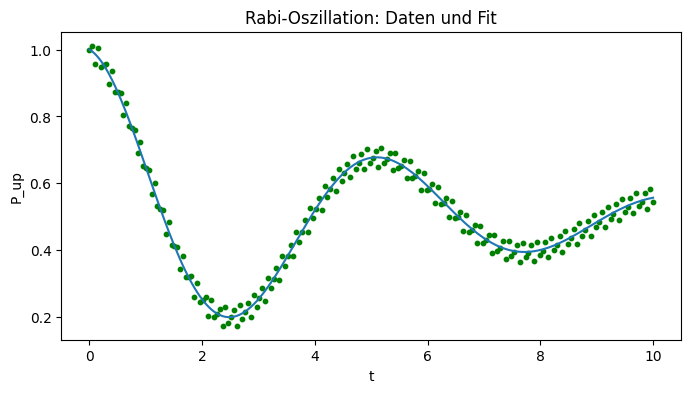

In [350]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Rabi Modell Funktion
def rabi_model(t, A, Omega, T2, C): # Modellfunktion für Rabi-Oszillation mit Dämpfung
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t)) + C

# Daten
np.random.seed(1234)
t = np.linspace(0, 10, 200)
A_true, Omega_true, T2_true, C_true = 0.5, 1.2, 5.0, 0.0

P = rabi_model(t, A_true, Omega_true, T2_true, C_true)
noise = 0.03*np.sin(50* t)
P_noisy = P + noise #hier wird ledeiglich Rauschen hinzuaddiert

# Fit Funktion auf die Daten anwenden
p0 = [0.4, 1.0, 4.0, 0.0]  # Startwerte
popt, pcov = curve_fit(rabi_model, t, P_noisy, p0=p0)
perr = np.sqrt(np.diag(pcov))

A_fit, Omega_fit, T2_fit, C_fit = popt
A_err, Omega_err, T2_err, C_err = perr

# Ergebnisse der Fit Parameter ausgeben
print("Fit-Parameter:")
print(f"A     = {A_fit:.4f} ± {A_err:.4f}")
print(f"Omega = {Omega_fit:.4f} ± {Omega_err:.4f}")
print(f"T2    = {T2_fit:.4f} ± {T2_err:.4f}")
print(f"C     = {C_fit:.4f} ± {C_err:.4f}")

# Plot
plt.figure(figsize=(8,4))
plt.scatter(t, P_noisy, s=10, color='green')
plt.plot(t, rabi_model(t, *popt))
plt.xlabel("t")
plt.ylabel("P_up")
plt.title("Rabi-Oszillation: Daten und Fit")
plt.show()


Hierbei wird sichtbar, dass man diese Art von Rauschen noch sehr gut mithilfe einer Fit Funktion bereinigen kann. 

## Rabi Oszillation mit Ornstein Uhlenbeck Rauschen ##

Jedoch ist das hinzuaddierte weiße Rauschen nicht vergleichbar mit dem physikalischen Effekt, welchen Magnetfeldschwankungen auf die T2 Zeit haben. Magnetfeldrauschen $\Delta (t)$ erzeugt Frequenzrauschen $\delta \omega (t)$, woraus durch Zeitentwicklung eine akkumulierte Phase entsteht: $ \phi= \int_{t_0}^{t_0+\tau} \Delta(t) dt$ Als nächstes wird die das Rauschen direkt in die Simulation der Rabi-Frequenz miteingerechnet. Dies geschieht mithilfe eines Ornstein Uhlenbeck Prozesses, wodurch normalverteiltes Rauschen simuliert werden kann. Dieser Prozess wird wie folgt implementiert: $dx(t) = -\theta x(t) dt+ \sigma dW(t)$

x(t) ist in diesem Fall das Rauschen, sprich: $\delta \omega$
dW(t) ist die Gaussche Variable zwischen 0 und 1.
$\sigma$ ist die Amplitude des Rauschens

$\theta$ ist die "Reversion rate" - wie stark das Rauschen zu 0 abfällt, bzw. zurückgestellt wird.

Fit-Parameter:
A     = 0.5182 ± 0.0252
Omega = 1.2528 ± 0.0127
T2    = 4.3139 ± 0.3326
C     = 0.0204 ± 0.0267


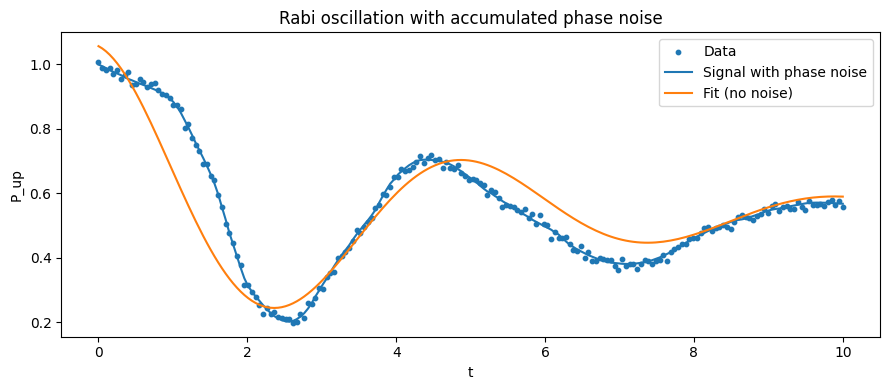

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ornstein Uhlenbeck Noise Funktion
def ou_noise(dt, steps, theta=1.0, sigma=0.6):
    x = np.zeros(steps)
    for i in range(1, steps):
        x[i] = x[i-1] + (-theta*x[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
    return x

# Rabi Model inkl. Phi (akkumulierte Phase)
def rabi_noisy(t, A, Omega, T2, C, phi):
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t + phi)) + C


np.random.seed(23994)

# Parameter
A_true, Omega_true, T2_true, C_true = 0.5, 1.2, 5.0, 0.0
t = np.linspace(0, 10, 200)
dt = t[1] - t[0]

# Ornstein Uhlenbeck Rauschen δω(t)
dw = ou_noise(dt, len(t), theta=1.0, sigma=1.0)

# Akkumulierte Phase φ(t) = ∫ δω(t') dt'
phi = np.cumsum(dw) * dt

# Rabi ohne Noise
P = rabi_noisy(t, A_true, Omega_true, T2_true, C_true, phi)

# Optionales Messrauschen hinzufügen
P_noisy = P + 0.01*np.random.randn(len(t))

# Fit Funktion ohne akkumulierte Phase
# T2 wird so angepasst, dass der Effekt des Rauschens teilweise kompensiert wird
def rabi_model_fit(t, A, Omega, T2, C):
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t)) + C

p0 = [0.4, 1.0, 4.0, 0.0]
popt, pcov = curve_fit(rabi_model_fit, t, P_noisy, p0=p0)
perr = np.sqrt(np.diag(pcov))

A_fit, Omega_fit, T2_fit, C_fit = popt
A_err, Omega_err, T2_err, C_err = perr

#Ergebnisse der Fit Parameter ausgeben
print("Fit-Parameter:")
print(f"A     = {A_fit:.4f} ± {A_err:.4f}")
print(f"Omega = {Omega_fit:.4f} ± {Omega_err:.4f}")
print(f"T2    = {T2_fit:.4f} ± {T2_err:.4f}")
print(f"C     = {C_fit:.4f} ± {C_err:.4f}")

# Plot
plt.figure(figsize=(9,4))
plt.scatter(t, P_noisy, s=10, label="Data")
plt.plot(t, P, label="Signal with phase noise")
plt.plot(t, rabi_model_fit(t, *popt), label="Fit (no noise)")
plt.xlabel("t")
plt.ylabel("P_up")
plt.title("Rabi oscillation with accumulated phase noise")
plt.legend()
plt.tight_layout()
plt.show()


Auch hier ist die Rabi Oszillation noch deutlich erkennbar und die Fit Funktion liefert eine leicht reduzierte $T_2$ Kohärenzzeit. Dies ist mit verstärktem Rauschen durchaus intuitiv konsitent.

## Ramsey Experiment ##

Das Ramsey Experiment besteht aus folgenden Schritten:
1. Vorbereitung des Qubits im Grundzustand |0⟩.
2. Anwendung eines π/2-Pulses, um das Qubit in eine Superposition aus |0⟩ und |1⟩ zu bringen.
3. Freie Evolution des Qubits für eine Zeitdauer τ, wobei es zu Dekohärenzprozessen kommt.
4. Anwendung eines weiteren π/2-Pulses, um das Qubit für die Messung vorzubereiten.
5. Messung des Qubits im Z-Basis, um die Wahrscheinlichkeit zu bestimmen, den Zustand |1⟩ zu finden.

## Bestimmung von $T_2$ über nichtlinearen Fit

Durch die Mittelung vieler Realisationen lässt sich die mittlere 
Rabi-Oszillation bestimmen. Die Dekohärenzhülle kann anschließend mit einem 
gedämpften Kosinus der Form

$
P(t) = A\, e^{-t/T_2} \cos(\Omega t + \phi) + C
$

gefittet werden. Die hier bestimmte $T_2$-Zeit entspricht dem effektiven 
Phasenkohärenzverlust des Systems, verursacht durch das simulierte Rauschen.


Für die 
Simulation des Ramsey Experiments mit Quiskit:

A = 1.0829130806750502
T2 = 8.266877808981944
omega = 1.0037002512551214
phi0 = -0.03982435825885432
C = -0.0031186489503375924


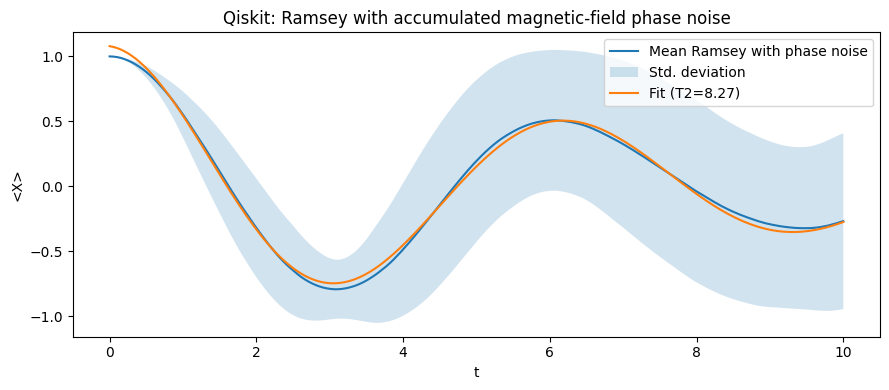

In [352]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli
from scipy.optimize import curve_fit


# Rauschfunktion: Ornstein Uhlenbeck Prozess
def ou_noise(dt, steps, theta=1.0, sigma=0.6):
    x = np.zeros(steps)
    for i in range(1, steps):
        x[i] = x[i-1] + (-theta*x[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
    return x


# Ramsey-Schaltkreis mit akkumuliertem Phasenrauschen
def ramsey_phase(phi):
    qc = QuantumCircuit(1)
    qc.ry(np.pi/2, 0) # Erstes Hadamard
    qc.rz(phi, 0)   # Akkumulierter Phase aus B-Feld Rauschen
    qc.rx(np.pi/2,0) # Hadamard mit Phasenverschiebung
    return qc


# Expectation value des Pauli X berechnen
def exp_X(state):
    X = Pauli("X")
    return state.expectation_value(X).real


# Parameter für die Simulation
np.random.seed(1234)

T = np.linspace(0, 10, 200)
dt = T[1]-T[0]

num_runs = 100            # Anzahl der Simulationen für Mittelwertbildung



all_signals = []
for _ in range(num_runs):
    #Rausch δω(t)
    dw = ou_noise(dt, len(T), theta=1.0, sigma=0.5)

    # akkumulierte Phase φ(t) + Rotationsfrequenz omega
    omega= 1.0 #rad/s 
    phi = omega * T + np.cumsum(dw) * dt


    # Quiskit
    signal = []
    for ph in phi:
        qc = ramsey_phase(ph)
        sv = Statevector.from_label("0").evolve(qc)
        signal.append(exp_X(sv))

    all_signals.append(signal)
all_signals = np.array(all_signals)
mean_signal = np.mean(all_signals, axis=0)
std_signal = np.std(all_signals, axis=0)


# Fit für T2 
def full_model(t, A, T2, omega, phi0, C):
    return A * np.exp(-t / T2) * np.cos(omega * t + phi0) + C

def full_model(t, A, T2, omega, phi0, C):
    return A * np.exp(-t / T2) * np.cos(omega * t + phi0) + C

# anfängliche Parameter schätzen
A0 = 1.0
T20 = 5.0
omega0 = 1.0           # Rabi Frequenz
phi00 = 0.0            # Afangsphase
C0 = 0.0               # Offset

# Curve Fit wie bisher

p0 = [A0, T20, omega0, phi00, C0]

popt, pcov = curve_fit(full_model, T, mean_signal, p0=p0)
A_fit, T2_fit, omega_fit, phi_fit, C_fit = popt

#Ausgabe der Fit Parameter
print("A =", A_fit)
print("T2 =", T2_fit)
print("omega =", omega_fit)
print("phi0 =", phi_fit)
print("C =", C_fit)

#Plot
plt.figure(figsize=(9,4))
plt.plot(T, mean_signal, label="Mean Ramsey with phase noise")

plt.fill_between(T, mean_signal - std_signal, mean_signal + std_signal, alpha=0.2, label="Std. deviation")

plt.plot(T, full_model(T, *popt), label=f"Fit (T2={T2_fit:.2f})")
plt.xlabel("t")
plt.ylabel("<X>")
plt.title("Qiskit: Ramsey with accumulated magnetic-field phase noise")
plt.legend()
plt.tight_layout()
plt.show()

### Hilbert Transformation ###

## Extraktion der Dekohärenzhülle mit der Hilbert-Transformation

Eine robustere Methode zur Bestimmung der Dekohärenzhülle ist die 
Hilbert-Transformation. Für ein Signal \(s(t)\) definiert man die analytische 
Fortsetzung

$
s_a(t) = s(t) + i\,\mathcal{H}\{s(t)\},
$

wobei $\mathcal{H}\cdot $ die Hilbert-Transformation ist. Die Modulusfunktion

$
A(t) = |s_a(t)|
$

liefert direkt die Einhüllende der Oscillation. Durch Fit eines exponentiellen 
Abfalls erhält man eine alternative Schätzung von $T_2$.


/Users/benbettin/Desktop/Freiburg Master/QUPrakt/.venv311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benbettin/Desktop/Freiburg Master/QUPrakt/.venv311/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


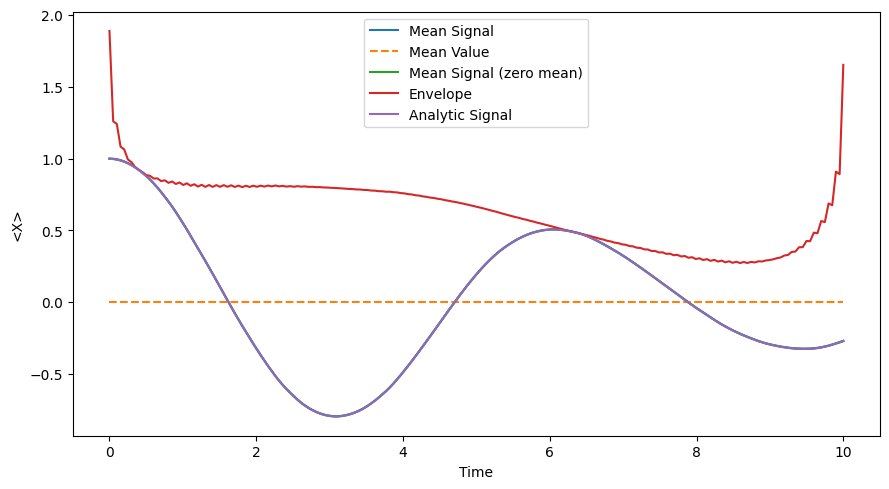

T2 (envelope) = 7.037430727198718


In [353]:
from scipy.signal import hilbert
from scipy.optimize import curve_fit
import numpy as np

# inputs: T (times), mean_signal (ensemble average)


# Frequenzanalyse via Hilbert-Transformation
analytic = hilbert(mean_signal - mean_signal.mean())
envelope = np.abs(analytic)

plt.figure(figsize=(9,5))

# 1) Durchschnittssignal aus vorheriger Zelle
plt.plot(T, mean_signal, label="Mean Signal")

# 2) Mittelwert
plt.plot(T, np.full_like(T, mean_signal.mean()), '--', label="Mean Value")

# 3) Zero-mean signal
plt.plot(T, mean_signal - mean_signal.mean(), label="Mean Signal (zero mean)")

# 4) Envelope
plt.plot(T, envelope, label="Envelope")
plt.plot(T, analytic, label="Analytic Signal")
plt.xlabel("Time")
plt.ylabel("<X>")
plt.legend()
plt.tight_layout()
plt.show()

def env_exp(t, A, T2, C):
    return A * np.exp(-t / T2) + C

p0 = [envelope.max()-envelope.min(), (T[-1]-T[0])/3, envelope.min()]
popt, pcov = curve_fit(env_exp, T, envelope, p0=p0)
A_e, T2_e, C_e = popt
print("T2 (envelope) =", T2_e)


## Bloch-Vektordynamik unter reinem Dephasierungsrauschen

Im Falle von magnetisch induziertem Phasenrauschen wirkt der Hamiltonoperator 
nur über die $ \sigma_z $-Komponente:

$
H(t) = \frac{1}{2}(\omega + \delta\omega(t))\,\sigma_z.
$

Dies führt zu einer deterministischen Rotation des Bloch-Vektors um die 
$z$-Achse, überlagert mit stochastischen Fluktuationen. Die transversale 
Komponente

$
\langle \sigma_x(t) \rangle + i \langle \sigma_y(t) \rangle = e^{-t/T_2}
$

nimmt exponentiell ab, während $ \langle \sigma_z \rangle $ unverändert bleibt.  
Dies entspricht der typischen **Phase-Dekohärenz** eines Zwei-Niveau-Systems.


### Bloch Vector Darstellung ###

Start Coords:  1.0 -2.220446049250313e-16 0.0
End Coords:  -0.47495267223788784 0.0 0.8800113403440263


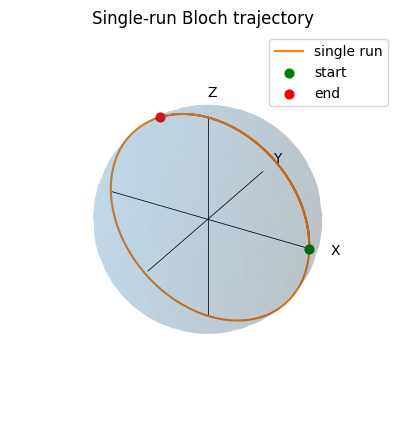

In [354]:
sigma_noise = 0.6

dw = ou_noise(dt, len(T), theta=1.0, sigma=sigma_noise)
phi_single = omega * T + np.cumsum(dw) * dt


X = Pauli("X")
Y = Pauli("Y")
Z = Pauli("Z")

def bloch_components(sv: Statevector):
    # returns (x, y, z) real floats
    x = sv.expectation_value(X).real
    y = sv.expectation_value(Y).real
    z = sv.expectation_value(Z).real
    return np.real_if_close([x, y, z]).astype(float)

bloch_traj = np.zeros((len(T), 3))
for i, ph in enumerate(phi_single):
    qc = ramsey_phase(ph)
    sv = Statevector.from_label("0").evolve(qc)
    bloch_traj[i] = bloch_components(sv)

def plot_bloch_sphere(ax, alpha=0.15):
    # draw a translucent unit sphere
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2, linewidth=0, alpha=alpha, zorder=0)
    # axes lines
    ax.plot([-1,1],[0,0],[0,0],'k-', lw=0.6)
    ax.plot([0,0],[-1,1],[0,0],'k-', lw=0.6)
    ax.plot([0,0],[0,0],[-1,1],'k-', lw=0.6)
    # labels
    ax.text(1.2, 0, 0, 'X', fontsize=10)
    ax.text(0, 1.2, 0, 'Y', fontsize=10)
    ax.text(0, 0, 1.2, 'Z', fontsize=10)
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_box_aspect((1,1,1))
    ax.axis('off')

fig = plt.figure(figsize=(12,5))

#  single-run trajectory on Bloch sphere
ax1 = fig.add_subplot(121, projection='3d')
plot_bloch_sphere(ax1)

# plot the path
ax1.plot(bloch_traj[:,0], bloch_traj[:,1], bloch_traj[:,2], lw=1.5, label='single run')
# mark start and end
ax1.scatter([bloch_traj[0,0]],[bloch_traj[0,1]],[bloch_traj[0,2]], color='green', s=40, label='start')
ax1.scatter([bloch_traj[-1,0]],[bloch_traj[-1,1]],[bloch_traj[-1,2]], color='red', s=40, label='end')
ax1.set_title('Single-run Bloch trajectory')

ax1.legend()
print("Start Coords: ", bloch_traj[0,0], bloch_traj[0,1], bloch_traj[0,2])
print("End Coords: ", bloch_traj[-1,0], bloch_traj[-1,1], bloch_traj[-1,2])

## Teil 2: Simulation

Zur Simulation des zweil Level Atoms brauchen benutze ich folgenden Hamiltonian: $H = \frac{\Delta}{2}\sigma_z + \frac{\Omega}{2}\sigma_x$
Hierbei ist $\Delta = \omega_q - \omega_l $ das Detuning des Lasers, welcher die Pulse für das Ramsey Experiment ausführt und $\Omega$ ist die Rabi Frequenz. Diese ist abhängig von der Laserintensität, der Menge an Photonen, und der Coupling - Stärke $N_L,d_{coupling}$. Diese variiert je nach Art des Qubits (optisch oder hyperfine) oder den gewählten Energiezuständen für die Realisierung des Qubits.
$\sigma_x$ ist das Pauli-X, was einer Rotation um die X-Achse der Bloch Kugel entspricht.Gleichermaßen ist $\sigma_z$ eine Rotation umd die z-Achse.
Durch die Änderung der Paramter in den folgenden Funktionen bzw. der Main Loop können nun sowohl hyperfeine als auch optische Qubits in einem schankenden Magnetfeld simuliert werden.

In [355]:
# Hamiltonian
"""
- Hamiltonian: H(t) = 0.5 * Delta(t) * sz + 0.5 * Omega(t) * sx
- Delta(t) = Delta0 + Field_sensitivity* OU_noise(t)
- Omega(t) sind quadratische Pulse für pi/2 Pulse; hier muss noch coupling rein
"""

import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import Operator, Statevector   
import matplotlib.pyplot as plt
from qutip import basis, sigmax, sigmay, sigmaz, sigmam, mesolve

#Pauli Matrizen 
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
proj1 = np.array([[0, 0], [0, 1]], dtype=complex)

# als quiskit Operator

SX = Operator(sx)
SZ = Operator(sz)

# Physikalische Konstanten

epsilon0 = 8.854187817e-12
c_light = 299792458.0
hbar = 1.054571817e-34
mu_B = 9.2740100783e-24
hbar = 1.054571817e-34
c= 299792458

In [356]:
#Funktionen zur Berechnung von E Feld und Rabi Frequenz für optische Qubits

def E_from_power(P, area):
    """Ungefähres E Feld Peak durch Laserdaten. Beam area & Laserleistung."""
    return np.sqrt(2.0 * P / (c_light * epsilon0 * area))

def Omega_from_power_and_dipole(P, area, d):
    """Gibt Omega0 (rad/s) anhand von Laserleistung P (W), Beam area A (m^2) und Dipole moment d (C*m).
       Nutzt E ≈ sqrt(2P/(c eps0 A)) und Omega = d E / ħ."""
    E0 = E_from_power(P, area)
    return (d * E0) / hbar

In [357]:
#Funktion zur Berechnung der Rabi Frequenz für Hyperfeine Qubits

def rabi_freq_mw(B1, gF, C=1.0):
    """
    B1: MW magnetic field (Tesla)
    gF: Hyperfine g-factor
    C : Coupling Matrix Element (Clebsch-Gordan)
    """
    return gF * mu_B * B1 * C / hbar

In [ ]:
# Ornstein–Uhlenbeck Rauschen, wie bisher. Das ist die Quelle des Rauschens für das Magnetfeld. Die Parameter müssen in der Main Loop passend gewählt werden.

def generate_ou_noise(n_steps, dt, tau, sigma_field, rng=None):
    """
    Erzeugt Ornstein-Uhlenbeck-Prozess für Feld-Fluktuationen.
    - sigma_field: stationäre Standardabweichung in Tesla.
      Einheit muss konsistent mit 'field_sensitivity' sein (rad/s per Tesla).
    Return: x (array) in der selben Einheit wie sigma_field.
    """
   
    if rng is None:
        rng = np.random.default_rng()

    alpha = np.exp(-dt / tau)
    sigma = sigma_field * np.sqrt(1 - alpha**2)

    x = np.zeros(n_steps)
    for k in range(1, n_steps):
        x[k] = alpha * x[k-1] + sigma * rng.standard_normal()

    return x

#Pulsgenerator für das Ramsey Experiment
def gaussian_pulse(times, start, duration, amp, sigma_fraction=0.25):
    """
    Laserpulsgenerator: kreiert einen Gausschen Puls, mittig zwischen start und start+duration.
    die Amplitude ist die Rabi-Frequenz in rad/s.
    sigma_fraction: relative Breite, sigma = sigma_fraction * duration
    """
    pulse = np.zeros_like(times)
    center = start + 0.5 * duration
    sigma = sigma_fraction * duration
    mask = (times >= start) & (times < start + duration)
    tloc = times[mask]
    pulse[mask] = amp * np.exp(-0.5 * ((tloc - center) / sigma) ** 2)
    return pulse


# Ramsey Pulssequenz
# zwei pi/2 Pulse mit Wartezeit tau_wait dazwischen

def build_ramsey_pulses(times, omega_amp, pi_over_2_duration, tau_wait, phase2=np.pi/2, sigma_fraction=0.25):
    t0_pulse1 = 0.0
    t0_pulse2 = pi_over_2_duration + tau_wait

    # Erste pi/2 entlang x
    p1 = gaussian_pulse(times, t0_pulse1, pi_over_2_duration, omega_amp, sigma_fraction=sigma_fraction)
    # Zweite pi/2 mit Phase -> Komponenten x,y
    p2 = gaussian_pulse(times, t0_pulse2, pi_over_2_duration, omega_amp, sigma_fraction=sigma_fraction)
    p2_x = p2 * np.cos(phase2)
    p2_y = p2 * np.sin(phase2)

    # Gesamtsignale: erste Pulse nur in x, zweite hat x+y Anteile
    Omega_x = p1 + p2_x
    Omega_y = p2_y

    return Omega_x, Omega_y

#Zeitentwicklung für ein einzelnes Qubit
def evolve_single_realization(times, Omega_t, Delta_t, psi0):
    """
    Entwickelt den Zustand psi0 unter dem Hamiltonian H(t) = 0.5*Delta_t*sz + 0.5*Omega_t*sx mittels kurzer Zeitschritte.
    Gibt das Populationsarray für |1><1| zurück.
    """
    dt = times[1] - times[0]
    psi = psi0.copy()
    pops = np.zeros(len(times))
    for i, t in enumerate(times):
        H = 0.5 * Delta_t[i] * sz + 0.5 * Omega_t[i] * sx
        U = expm(-1j * H * dt)
        psi = U @ psi
        pops[i] = np.abs(psi[1])**2
    return pops

Problem: bis jetzt fehlt noch die "normale Decoherence", nur Änderungen im Magnetfeld reichen nicht zur vollständigen Simulation aus. 
Dafür muss die Lindblad Gleichung mit dem bisherigen Hamiltonian gelöst werden.
Das ist auch mit QUiskit möglich, jedoch hatte ich Probleme mit der Kompatibilität von Quiskit-solver und quiskit_aer. Aus diesem Grund habe ich mich dazu entschieden auf Qutip umzusteigen:

Die Ramsey Sequenz wird nun folgendermaßen ausgeführt:

In [385]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmax, sigmay, sigmaz, mesolve

# Pauli matrices
sx = sigmax()
sy = sigmay()
sz = sigmaz()

def run_ramsey_ensemble(
    Delta0,
    Omega_amp,
    pi_over_2_duration,
    tau_wait,
    dt,
    T1,
    Tphi,
    tau_corr,
    sigma_field,
    field_sensitivity,
    n_realizations,
    tpad=0.0,
):
    t_total = 2 * pi_over_2_duration + tau_wait + tpad
    times = np.arange(0.0, t_total, dt)
    n_steps = len(times)

    # Erzeuge Pulskomponenten (x,y)
    Omega_x, Omega_y = build_ramsey_pulses(times, Omega_amp, pi_over_2_duration, tau_wait)
    # Optional: Plot Pulse
   
    plt.plot(times, Omega_x, label='Omega_x'); 
    plt.plot(times, Omega_y, label='Omega_y'); 

    plt.xlabel("Time (s)"); 
    plt.ylabel("Rabi Frequency (rad/s)")
    plt.title("Ramsey Pulse Sequence")
    plt.legend()
    plt.show()

    pop_matrix = np.zeros((n_realizations, n_steps))
    bloch_matrix = np.zeros((n_realizations, n_steps, 3))
    rng = np.random.default_rng()

    rho0 = basis(2,0) * basis(2,0).dag()

    # Interpolatoren (schnell zugänglich in H_t_func)
    from scipy.interpolate import interp1d
    Omega_x_interp = interp1d(times, Omega_x, kind='linear', fill_value=0.0, bounds_error=False)
    Omega_y_interp = interp1d(times, Omega_y, kind='linear', fill_value=0.0, bounds_error=False)
    p1, p2 = gaussian_pulse(times, 0, pi_over_2_duration, Omega_amp), gaussian_pulse(times, pi_over_2_duration+tau_wait, pi_over_2_duration, Omega_amp)
    print("p1 max:", np.max(p1))
    print("p2 max:", np.max(p2))
    for r in range(n_realizations):
        # OU noise für detuning
        delta_field = generate_ou_noise(n_steps, dt, tau_corr, sigma_field, rng=rng)
        Delta_t = Delta0 + delta_field**2 * field_sensitivity
        Delta_interp = interp1d(times, Delta_t, kind='linear', fill_value="extrapolate", bounds_error=False)

        # Hamiltonian-Callable: gibt Qobj zurück
        def H_t_func(t, args):
            return 0.5 * float(Delta_interp(t)) * sz + \
                   0.5 * float(Omega_x_interp(t)) * sx + \
                   0.5 * float(Omega_y_interp(t)) * sy

        # Lindblad-Operatoren
        gamma1 = 1.0 / T1 if T1 is not None and T1 > 0 else 0.0
        gammaphi = 1.0 / (2.0 * Tphi) if Tphi is not None and Tphi > 0 else 0.0

        c_ops = []
        if gamma1 > 0:
            c_ops.append(np.sqrt(gamma1) * sigmam())
        if gammaphi > 0:
            # Alternative: use sigma_z dephasing as Linblad operator (works)
            c_ops.append(np.sqrt(gammaphi) * sz)

        # Erwartungsoperatoren: sx, sy, sz und Population |1><1|
        e_ops = [sx, sy, sz, basis(2,1) * basis(2,1).dag()]

        result = mesolve(H_t_func, rho0, times, c_ops, e_ops=e_ops)

        # result.expect ist shape (len(e_ops), n_steps)
        expect = np.array(result.expect)  # (4, n_steps)

        # Korrekt: einmalig zuweisen (kein Loop über states)
        pop_matrix[r, :] = np.real(expect[-1, :])
        bloch_matrix[r, :, 0] = np.real(expect[0, :])
        bloch_matrix[r, :, 1] = np.real(expect[1, :])
        bloch_matrix[r, :, 2] = np.real(expect[2, :])

        # optional debug plot für erste Realisierung
        if r == 0:
            plt.figure()
            plt.plot(times, Delta_t, label='Delta(t)')
            plt.plot(times, Omega_x, label='Omega_x (pulse)')
            plt.plot(times, Omega_y, label='Omega_y (pulse)')
            #plt.legend(); 
            #plt.show()

    pop_avg = pop_matrix.mean(axis=0)
    t0_p2 = pi_over_2_duration + tau_wait
    mask = (times >= t0_p2) & (times < t0_p2 + pi_over_2_duration)
    print("samples in 2nd pulse:", mask.sum())
    print("total dt, pi/2 dur, dt/pi/2:", dt, pi_over_2_duration, pi_over_2_duration/dt)
    print("sum(Omega_x) over 2nd pulse:", Omega_x[mask].sum(), "sum(Omega_y):", Omega_y[mask].sum())
    return times, pop_avg, pop_matrix[0, :], delta_field, pop_matrix, bloch_matrix[0,:,:], bloch_matrix



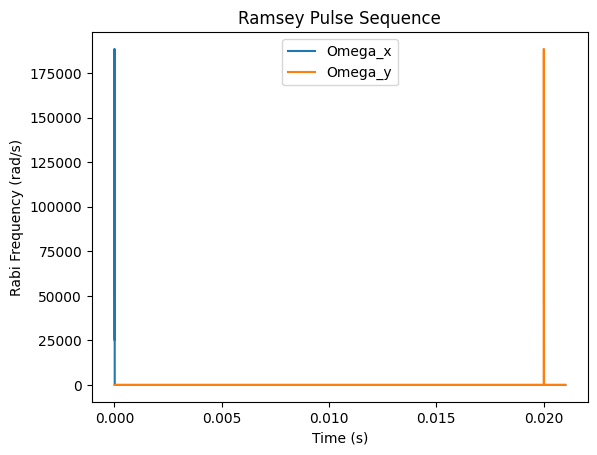

p1 max: 188495.5592153876
p2 max: 188495.5592153876
samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579343e-10 sum(Omega_y): 11274408.77710355


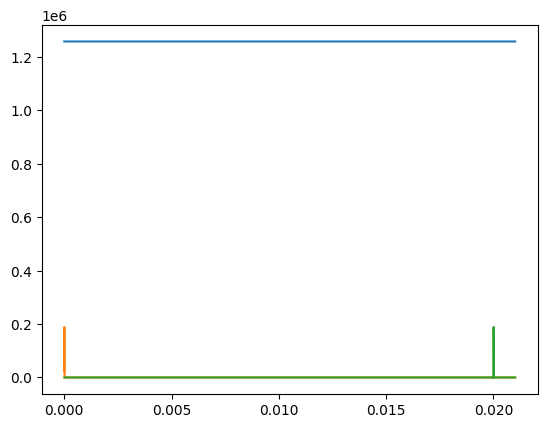

In [386]:
#Main Programm, hier können die Parameter für das Ramsey Experiment eingestellt werden.

if __name__ == "__main__":
    # Qubit und Laser omgea (Beispielwerte)
    omega_q_hz = 1762.97e6  # Hz
    omega_laser_hz = 1762.77e6
    Delta0_hz = omega_q_hz - omega_laser_hz
    Delta0 = 2 * np.pi * Delta0_hz  # rad/s

    # Wähle realistische Rabi-Frequenz, je nach System:

    #Optisches Qubit Beispiel
    P= 0.2 # Laserleistung in Watt
    area= 1e-8 # m^2 Beam area
    d= 3.584e-29 # C*m Dipolmoment
    

    #Omega_amp= Omega_from_power_and_dipole(P, area, d)

    #Hyperfein Qubit Beispiel 
    gF = 1.0       # Landé-Faktor
    C  = 1.0       # Clebsch-Gordan (Δm=0 Transition)
    B1 = 10.9e-3      # MW Feldstärke in Tesla 
    
    Omega_amp= 30e3 *np.pi*2 #rabi_freq_mw(B1, gF, C=1.0) #Rabi Frequenz in rad/s #insert coupling strength here
    omega_amp_hz = Omega_amp / (2.0 * np.pi)  # in Hz

    pi_over_2_duration = np.pi / (2.0 * Omega_amp)  # in s

    tau_wait = 2e-2   # Wartezeit zwischen den pi/2 Pulsen in s

    # field sensitivity: rad/s per Tesla - ändern je nach Qubit System
    field_sensitivity = 2*np.pi * 700e3  # from mw2 paper
    #field_sensitivity_hz = gF*mu_B / (2*np.pi*hbar)
    #field_sensitivity = 2 * np.pi * field_sensitivity_hz  # rad/s per Tesla

    # OU: sigma_field in Tesla und tau_corr in s 
    tau_corr = 0.0001
    sigma_field = 1e-5  # Tesla

    #Zeitauflösung
    dt= pi_over_2_duration / 100.0  #s
    #dt = min(1e-6, pi_over_2_duration / 50.0) 
    n_realizations = 20
    


    times, pop_avg, pop_example, last_delta_field, pop_state_example, bloch_example, bloch_matrix = run_ramsey_ensemble(
        Delta0=Delta0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=tau_wait,
        dt=dt,
        T1=10,               # lange Relaxationszeit, für Hyperfein Qubits
        Tphi=0.01,             # #Beispiel Dephasierungszeit in s
        tau_corr=tau_corr,
        sigma_field=sigma_field,
        field_sensitivity=field_sensitivity,
        n_realizations=n_realizations,
        tpad=0.001,
    )
    
    

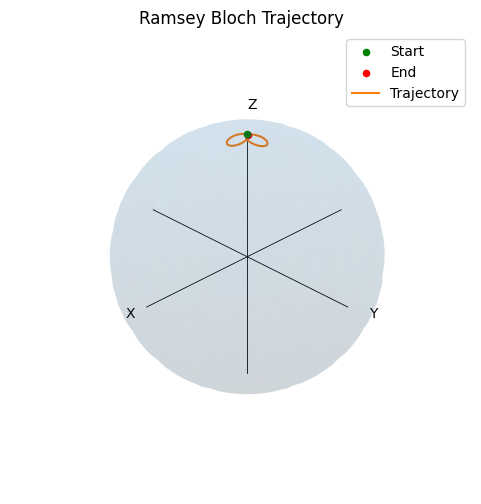

In [368]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Plot Bloch sphere
plot_bloch_sphere(ax, alpha=0.1)

# Start point
ax.scatter(
    [bloch_example[0,0]],
    [bloch_example[0,1]],
    [bloch_example[0,2]],
    color='green',
    label='Start'
)

# End point
ax.scatter(
    [bloch_example[-1,0]],
    [bloch_example[-1,1]],
    [bloch_example[-1,2]],
    color='red',
    label='End'
)

# Trajectory
ax.plot(
    bloch_example[:,0],
    bloch_example[:,1],
    bloch_example[:,2],
    lw=1.5,
    label='Trajectory'
)

ax.set_title('Ramsey Bloch Trajectory')
ax.view_init(elev=30, azim=45)
ax.legend()
plt.show()


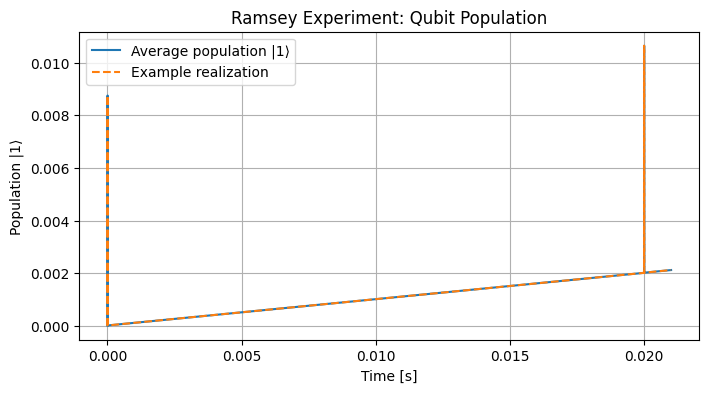

In [369]:
plt.figure(figsize=(8,4))
plt.plot(times, pop_avg, label="Average population |1⟩")
plt.plot(times, pop_example, '--', label="Example realization")
plt.xlabel("Time [s]")
plt.ylabel("Population |1⟩")
plt.title("Ramsey Experiment: Qubit Population")
plt.legend()
plt.grid(True)
plt.show()


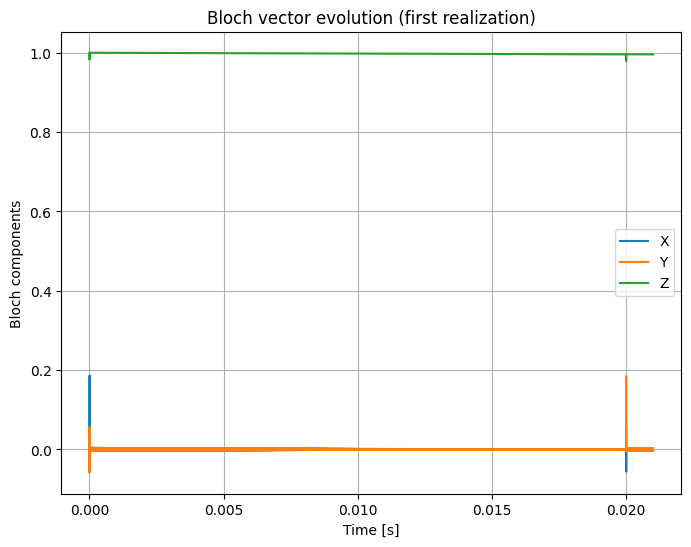

In [370]:
plt.figure(figsize=(8,6))
plt.plot(times, bloch_matrix[0,:,0], label="X")  # first realization
plt.plot(times, bloch_matrix[0,:,1], label="Y")
plt.plot(times, bloch_matrix[0,:,2], label="Z")
plt.xlabel("Time [s]")
plt.ylabel("Bloch components")
plt.title("Bloch vector evolution (first realization)")
plt.legend()
plt.grid(True)
plt.show()

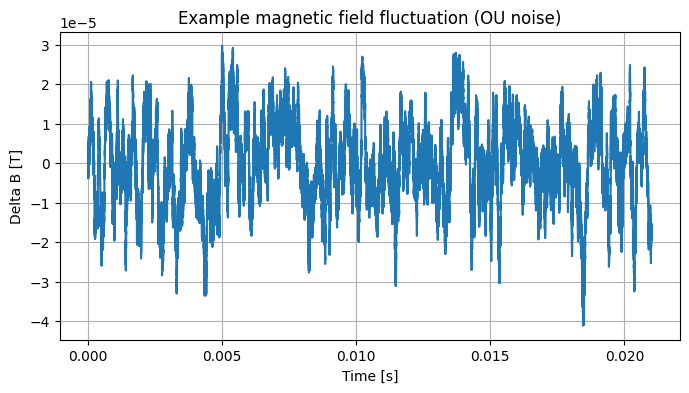

In [371]:
plt.figure(figsize=(8,4))
plt.plot(times, last_delta_field)
plt.xlabel("Time [s]")
plt.ylabel("Delta B [T]")
plt.title("Example magnetic field fluctuation (OU noise)")
plt.grid(True)
plt.show()


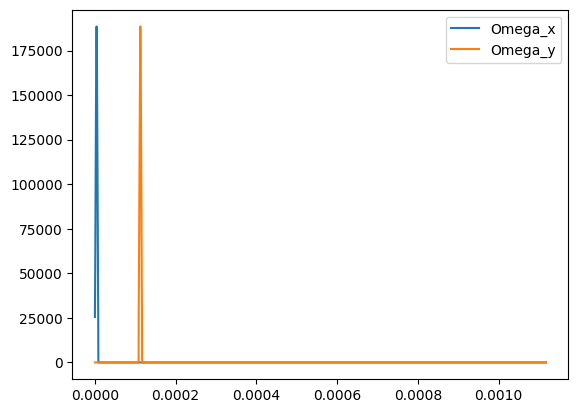

p1 max: 188495.5592153876
p2 max: 188495.5592153876


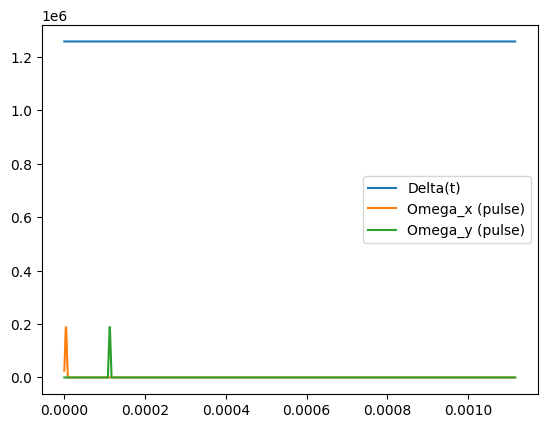

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579377e-10 sum(Omega_y): 11274408.777103601


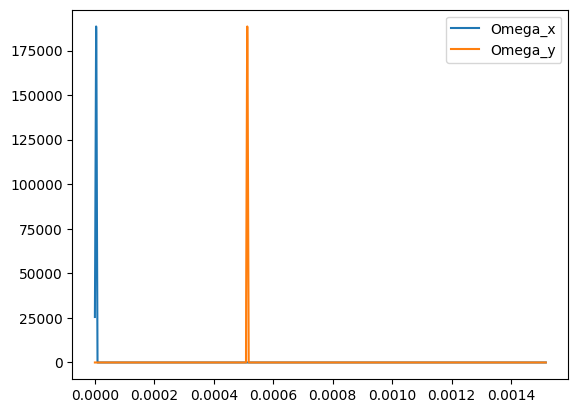

p1 max: 188495.5592153876
p2 max: 188495.5592153876


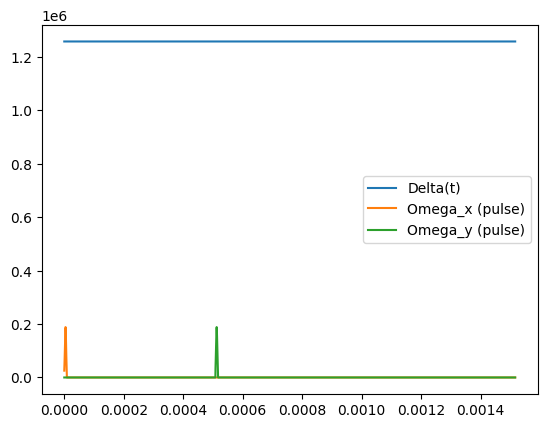

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579379e-10 sum(Omega_y): 11274408.777103608


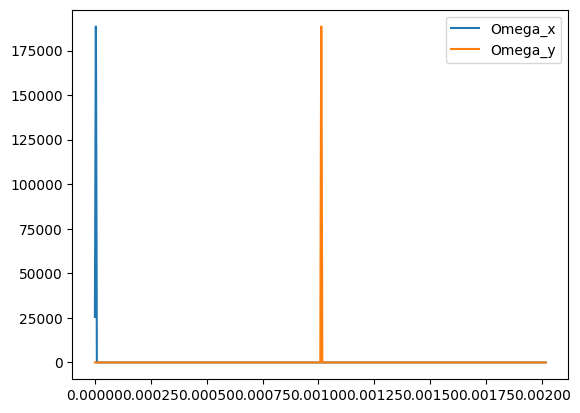

p1 max: 188495.5592153876
p2 max: 188495.5592153876


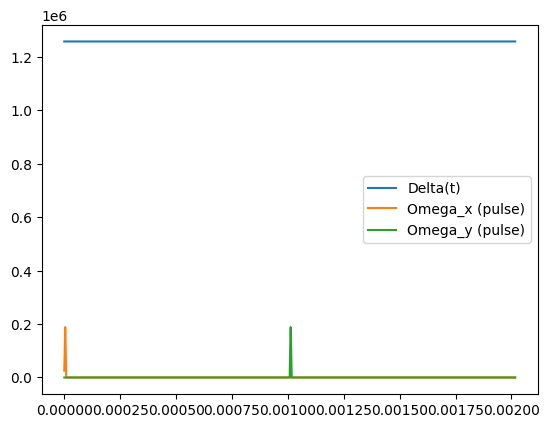

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579381e-10 sum(Omega_y): 11274408.77710361


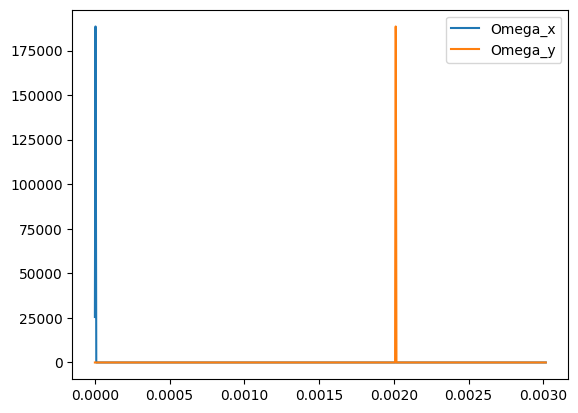

p1 max: 188495.5592153876
p2 max: 188495.5592153876


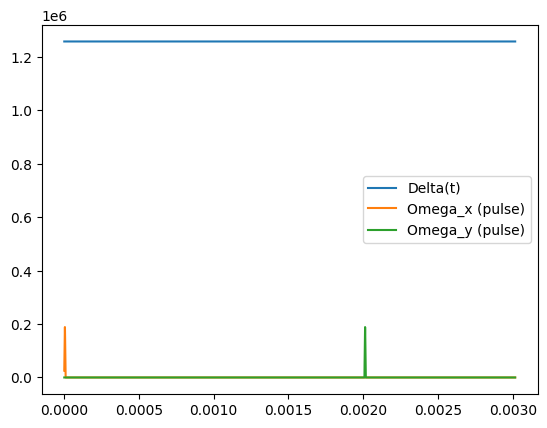

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579403e-10 sum(Omega_y): 11274408.777103648


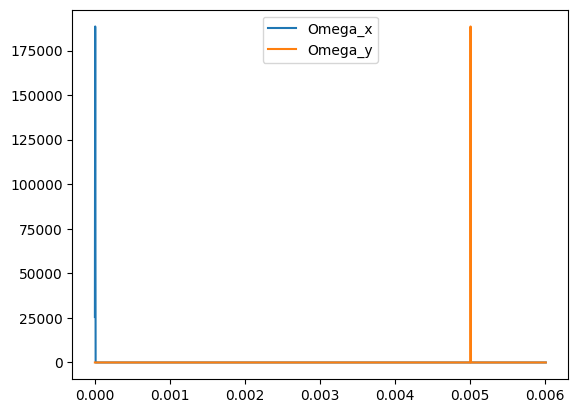

p1 max: 188495.5592153876
p2 max: 188495.5592153876


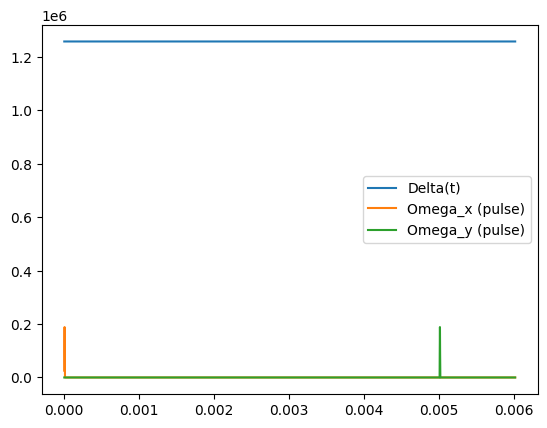

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.90358431057936e-10 sum(Omega_y): 11274408.777103579


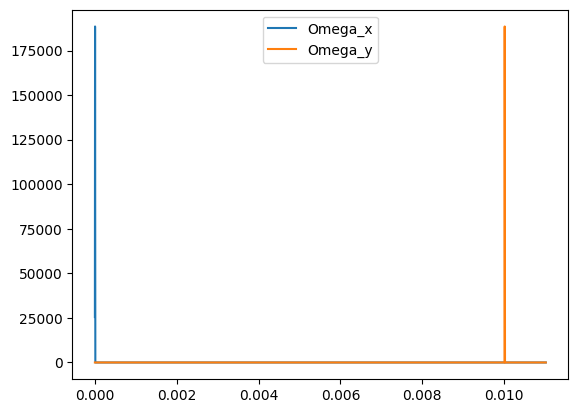

p1 max: 188495.5592153876
p2 max: 188495.5592153876


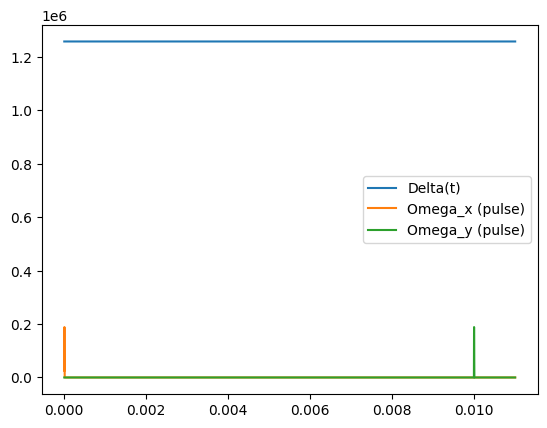

samples in 2nd pulse: 101
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.91920474167067e-10 sum(Omega_y): 11299918.876998808


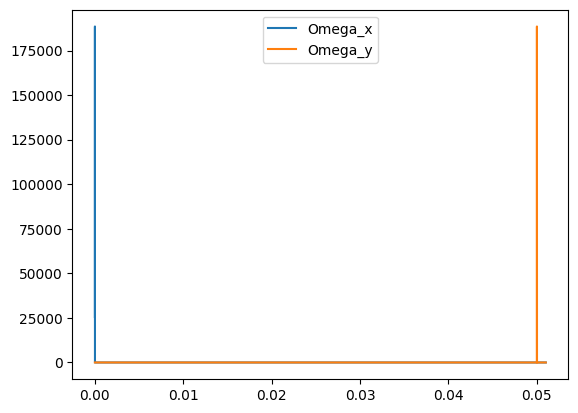

p1 max: 188495.5592153876
p2 max: 188495.5592153876


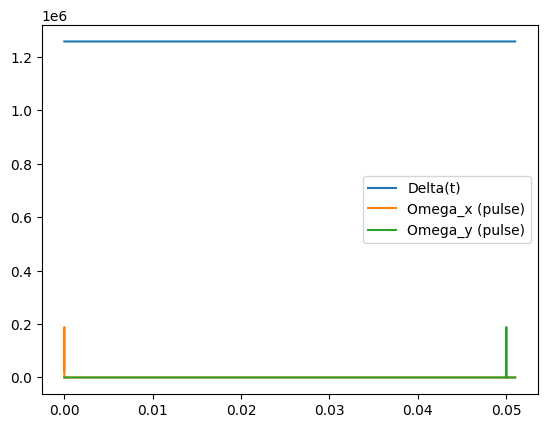

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.903584310579297e-10 sum(Omega_y): 11274408.777103473


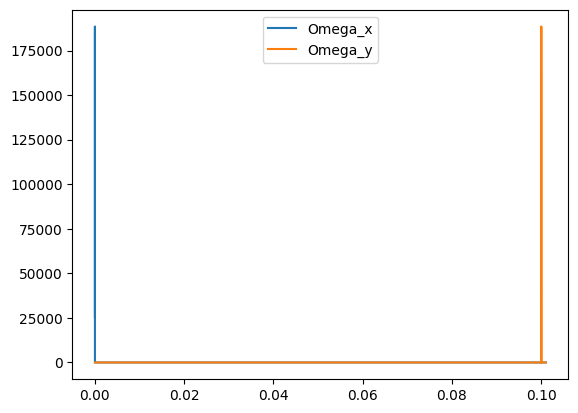

p1 max: 188495.5592153876
p2 max: 188495.5592153876


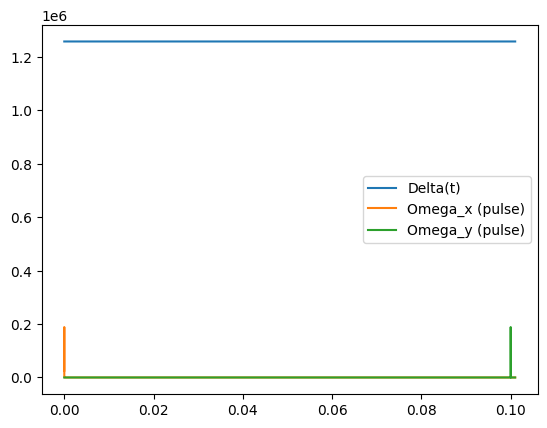

samples in 2nd pulse: 100
total dt, pi/2 dur, dt/pi/2: 8.333333333333334e-08 8.333333333333334e-06 100.0
sum(Omega_x) over 2nd pulse: 6.90358431057919e-10 sum(Omega_y): 11274408.7771033


In [375]:
tau_wait_list = np.array([1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 5e-2, 0.1])
contrast_list = []

for tau in tau_wait_list:
    times, pop_avg, pop_example, last_delta_field, pop_state_example, bloch_example, bloch_matrix = run_ramsey_ensemble(
        Delta0=Delta0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=tau,
        dt=dt,
        T1=1e-3,
        Tphi=280e-6,
        tau_corr=tau_corr,
        sigma_field=sigma_field,
        field_sensitivity=field_sensitivity,
        n_realizations=100,   # IMPORTANT: more averages give smoother T2
        tpad=0.001,
    )

    # Coherence from final Bloch vector
    xf, yf, zf = bloch_example[-1]
    C = np.sqrt(xf**2 + yf**2)
    contrast_list.append(C)

contrast_list = np.array(contrast_list)

def exp_decay(t, T2, C0):
    return C0 * np.exp(-t/T2)

popt, pcov = curve_fit(exp_decay, tau_wait_list, contrast_list, p0=[0.01, contrast_list[0]])
T2_fit = popt[0]


In [387]:
print(f"Fitted T2 from contrast decay: {T2_fit*1e3:.2f} ms")    

Fitted T2 from contrast decay: 5759974230.33 ms
